In [1]:
import os
import sys
from pathlib import Path

module_path = os.path.abspath(os.path.join('../vlad'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
from numpy.linalg import norm
import cv2
import matplotlib.pyplot as plt
import progressbar as pb

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from vlad import VLAD

In [5]:
query_path = Path('/home/tim/Hahn-Schickard/Bachelorarbeit/Datensätze/Eisengussteile/Typ668/00_Durchgang1')
db_path = Path('/home/tim/Hahn-Schickard/Bachelorarbeit/Datensätze/Eisengussteile/Typ668/01_Durchgang2')

query_files = sorted([x for x in query_path.iterdir() if x.is_file()], key=lambda x: int(x.name.split('_')[-1].split('.')[0]))
db_files = sorted([x for x in db_path.iterdir() if x.is_file()], key=lambda x: int(x.name.split('_')[-1].split('.')[0]))

## Testing with ORB-descriptors

In [7]:
_nfeatures = 1000

In [6]:
orb = cv2.ORB_create(_nfeatures, nlevels=4, scaleFactor=1.5)

In [46]:
DB_TENSOR_ORB = Path("db-tensor-orb.npy")

if not DB_TENSOR_ORB.exists():
    descs_lst = []
    for file in pb.progressbar(db_files):
        img = cv2.imread(str(file), 0)
        img = cv2.equalizeHist(img)
        _, descs = orb.detectAndCompute(img, None)
        descs_lst.append(descs[:_nfeatures])

    db_tensor = np.dstack(descs_lst)
    np.save(DB_TENSOR_ORB, db_tensor)
else:
    db_tensor = np.load(DB_TENSOR_ORB)

In [47]:
QUERY_TENSOR_ORB = Path("query-tensor-orb.npy")

if not QUERY_TENSOR_ORB.exists():
    descs_lst = []
    for file in pb.progressbar(query_files):
        img = cv2.imread(str(file), 0)
        img = cv2.equalizeHist(img)
        _, descs = orb.detectAndCompute(img, None)
        descs_lst.append(descs)

    query_tensor = np.dstack(descs_lst)
    np.save(QUERY_TENSOR_ORB, query_tensor)
else:
    query_tensor = np.load(QUERY_TENSOR_ORB)

In [9]:
VOCAB_FILE = Path("dictionary-orb.npy")
vlad_orb = VLAD()

if VOCAB_FILE.exists():
    vlad_orb.load_vocab(VOCAB_FILE)

vlad_orb.fit(db_tensor)

100% (1000 of 1000) |####################| Elapsed Time: 0:00:11 Time:  0:00:11


In [10]:
vlad.database.shape

(1000, 8192)

In [11]:
scores = np.zeros((query_tensor.shape[-1], vlad.database.shape[0]))

for i in pb.progressbar(range(len(scores))):
    scores[i] = vlad.predict_proba(query_tensor[...,i])

100% (999 of 999) |######################| Elapsed Time: 0:00:20 Time:  0:00:20


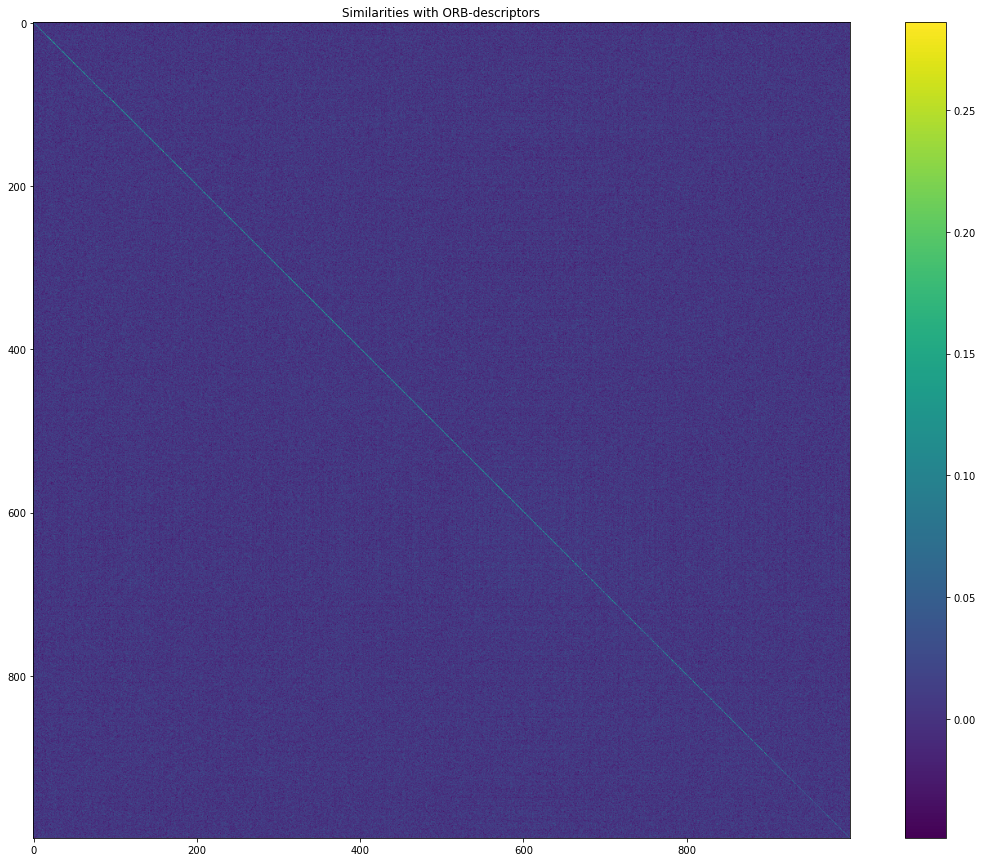

In [18]:
plt.figure(figsize=(20,15))
plt.imshow(scores)
plt.title("Similarities with ORB-descriptors")
plt.colorbar();

In [44]:
(np.argmax(scores, axis=1) != np.delete(np.arange(1000), 92)).sum()  # Count number of false classifications

36

One can see, that towards the end of the dataset the confidence goes down quite a bit. Let's see, if this is any different with RootSIFT-descriptors. Note, that i didn't search for good parameters for RootSIFT!

## RootSIFT

In [8]:
sift = cv2.SIFT_create(_nfeatures)

In [9]:
DB_TENSOR_SIFT = Path("db-tensor-sift.npy")

if not DB_TENSOR_SIFT.exists():
    descs_lst = []
    for file in pb.progressbar(db_files):
        img = cv2.imread(str(file), 0)
        img = cv2.equalizeHist(img)
        _, descs = sift.detectAndCompute(img, None)
        descs_lst.append(descs[:_nfeatures])

    db_tensor = np.dstack(descs_lst)
    np.save(DB_TENSOR_SIFT, db_tensor)
else:
    db_tensor = np.load(DB_TENSOR_SIFT)

In [10]:
QUERY_TENSOR_SIFT = Path("query-tensor-sift.npy")

if not QUERY_TENSOR_SIFT.exists():
    descs_lst = []
    for file in pb.progressbar(query_files):
        img = cv2.imread(str(file), 0)
        img = cv2.equalizeHist(img)
        _, descs = sift.detectAndCompute(img, None)
        descs_lst.append(descs[:_nfeatures])

    query_tensor = np.dstack(descs_lst)
    np.save(QUERY_TENSOR_SIFT, query_tensor)
else:
    query_tensor = np.load(QUERY_TENSOR_SIFT)

In [11]:
def RootSIFT(descs):
    if isinstance(descs, list):
        for i in range(len(descs)):
            descs[i] = np.sqrt(descs[i] / norm(descs, ord=1, axis=1))
    elif isinstance(descs, np.ndarray):
        descs = np.sqrt(descs / norm(descs, ord=1, axis=1)[:,np.newaxis])  # New axis in order to broadcast correctly
    else:
        print("{} not supported! Choose one of [list, numpy.ndarray].".format(type(descs)))
        return
    return descs

In [12]:
db_tensor = RootSIFT(db_tensor)  # SIFT -> RootSIFT
query_tensor = RootSIFT(query_tensor)

In [19]:
vlad_rs.qs[0].shape

(128, 128)

In [33]:
np.seterr(invalid='ignore', divide='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [29]:
vlad_rs = VLAD(norming="RN").fit(db_tensor)

Training KMeans...
Finding rotation-matrices...


N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--/home/tim/PycharmProjects/vlad/vlad/vlad.py:225: RuntimeWarning: invalid value encountered in true_divide
  V /= norm(V, axis=1)[:, None]  # L2-normalize every sum of residuals
/home/tim/PycharmProjects/vlad/vlad/vlad.py:225: RuntimeWarning: invalid value encountered in true_divide
  V /= norm(V, axis=1)[:, None]  # L2-normalize every sum of residuals
  0% (2 of 1000) |                       | Elapsed Time: 0:00:00 ETA:   0:01:09/home/tim/PycharmProjects/vlad/vlad/vlad.py:225: RuntimeWarning: invalid value encountered in true_divide
  V /= norm(V, axis=1)[:, None]  # L2-normalize every sum of residuals
/home/tim/PycharmProjects/vlad/vlad/vlad.py:225: RuntimeWarning: invalid value encountered in true_divide
  V /= norm(V, axis=1)[:, None]  # L2-normalize every sum of residuals
  0% (4 of 1000) |                       | Elapsed Time: 0:00:00 ETA:   0:01:21/home/tim/PycharmProjects/vlad/vlad/vlad.py:225: Runtim

In [30]:
scores = np.zeros((query_tensor.shape[-1], vlad_rs.database.shape[0]))

for i in pb.progressbar(range(len(scores))):
    scores[i] = vlad_rs.predict_proba(query_tensor[...,i])

N/A% (0 of 999) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--/home/tim/PycharmProjects/vlad/vlad/vlad.py:225: RuntimeWarning: invalid value encountered in true_divide
  V /= norm(V, axis=1)[:, None]  # L2-normalize every sum of residuals
/home/tim/PycharmProjects/vlad/vlad/vlad.py:225: RuntimeWarning: invalid value encountered in true_divide
  V /= norm(V, axis=1)[:, None]  # L2-normalize every sum of residuals
  0% (2 of 999) |                        | Elapsed Time: 0:00:00 ETA:   0:01:01/home/tim/PycharmProjects/vlad/vlad/vlad.py:225: RuntimeWarning: invalid value encountered in true_divide
  V /= norm(V, axis=1)[:, None]  # L2-normalize every sum of residuals
/home/tim/PycharmProjects/vlad/vlad/vlad.py:225: RuntimeWarning: invalid value encountered in true_divide
  V /= norm(V, axis=1)[:, None]  # L2-normalize every sum of residuals
  0% (4 of 999) |                        | Elapsed Time: 0:00:00 ETA:   0:01:00/home/tim/PycharmProjects/vlad/vlad/vlad.py:225: Runtim

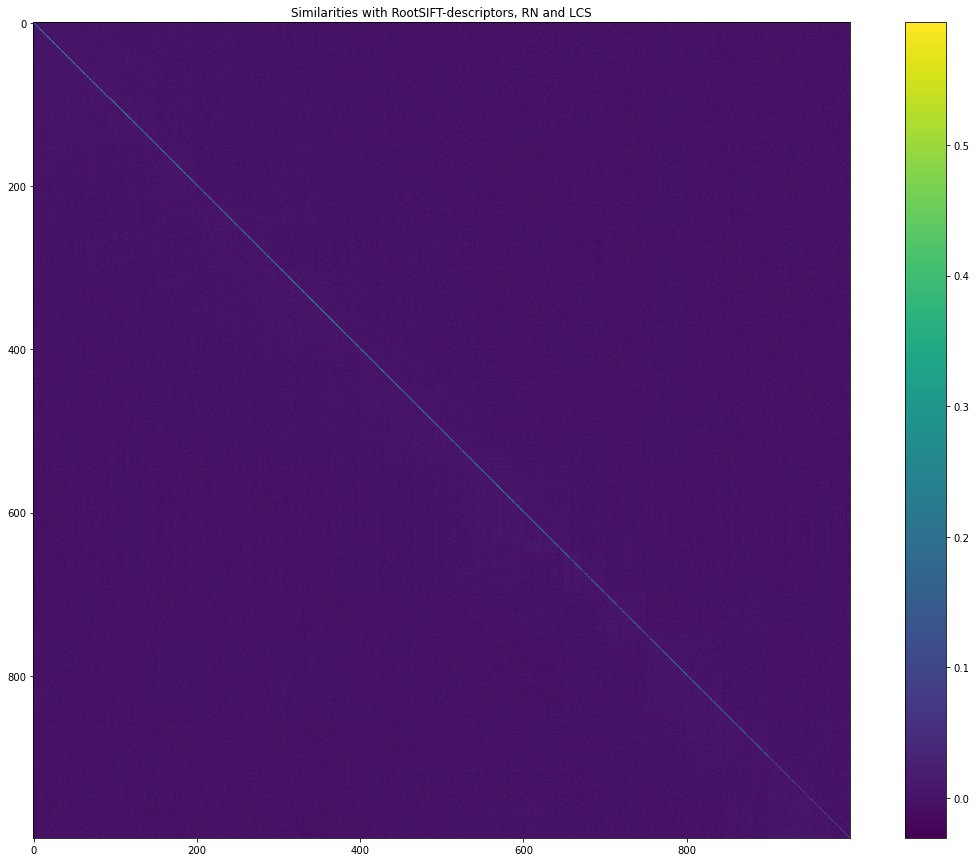

In [15]:
plt.figure(figsize=(20,15))
plt.imshow(scores)
plt.title("Similarities with RootSIFT-descriptors, RN and LCS")
plt.colorbar();

In [31]:
(np.argmax(scores, axis=1) != np.delete(np.arange(1000), 92)).sum()  # Count number of false classifications

0

---

In [174]:
query_mat = query_tensor.transpose((2, 0, 1)).reshape(-1, query_tensor.shape[1])
db_mat = db_tensor.transpose((2, 0, 1)).reshape(-1, db_tensor.shape[1])

In [175]:
db_mat.shape

(1000000, 128)

In [36]:
from sklearn.decomposition import PCA

In [176]:
pca = PCA(n_components=64)
db_mat_pca = pca.fit_transform(db_mat)

In [177]:
db_mat_pca.shape

(1000000, 64)

In [178]:
tmp = []
for i in range(db_tensor.shape[-1]):
    tmp.append(db_mat_pca[i*db_tensor.shape[0]:(i+1)*db_tensor.shape[0]])
db_tensor_pca = np.dstack(tmp)

In [179]:
db_tensor_pca.shape

(1000, 64, 1000)

In [201]:
vlad_pca = VLAD(norming="RN", lcs=True).fit(db_tensor_pca)

Training KMeans...
Finding rotation-matrices...


100% (1000 of 1000) |####################| Elapsed Time: 0:00:18 Time:  0:00:18


In [181]:
query_mat_pca = pca.transform(query_mat)

tmp = []
for i in range(query_tensor.shape[-1]):
    tmp.append(query_mat_pca[i*query_tensor.shape[0]:(i+1)*query_tensor.shape[0]])
query_tensor_pca = np.dstack(tmp)

In [202]:
scores_pca = np.zeros((query_tensor.shape[-1], vlad_pca.database.shape[0]))

for i in pb.progressbar(range(len(scores_pca))):
    scores_pca[i] = vlad_pca.predict_proba(query_tensor_pca[...,i])

100% (999 of 999) |######################| Elapsed Time: 0:00:28 Time:  0:00:28


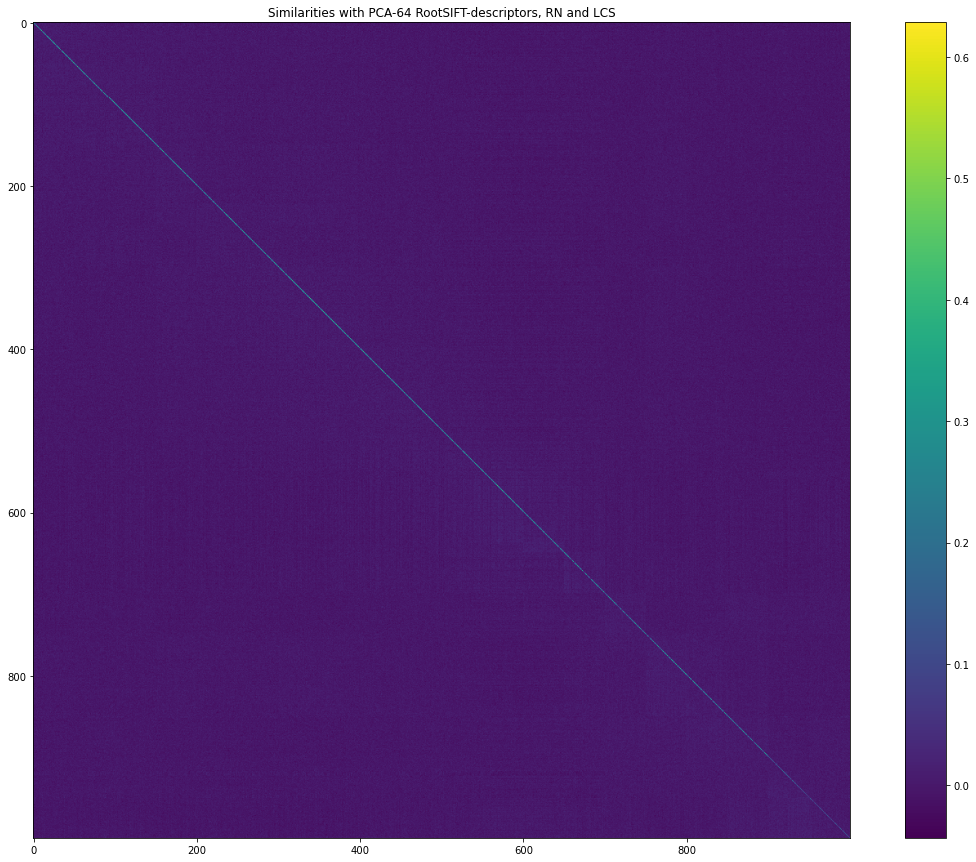

In [203]:
plt.figure(figsize=(20,15))
plt.imshow(scores_pca)
plt.title("Similarities with PCA-64 RootSIFT-descriptors, RN and LCS")
plt.colorbar();

In [204]:
(np.argmax(scores_pca, axis=1) != np.delete(np.arange(1000), 92)).sum()  # Count number of false classifications

1

In [186]:
import seaborn as sns

In [193]:
def separate_scores(scores):
    inter = np.fliplr(np.sort(scores))[:,1:]
    intra = scores.max(axis=1)
    return inter, intra

In [205]:
inter, intra = separate_scores(scores_pca)

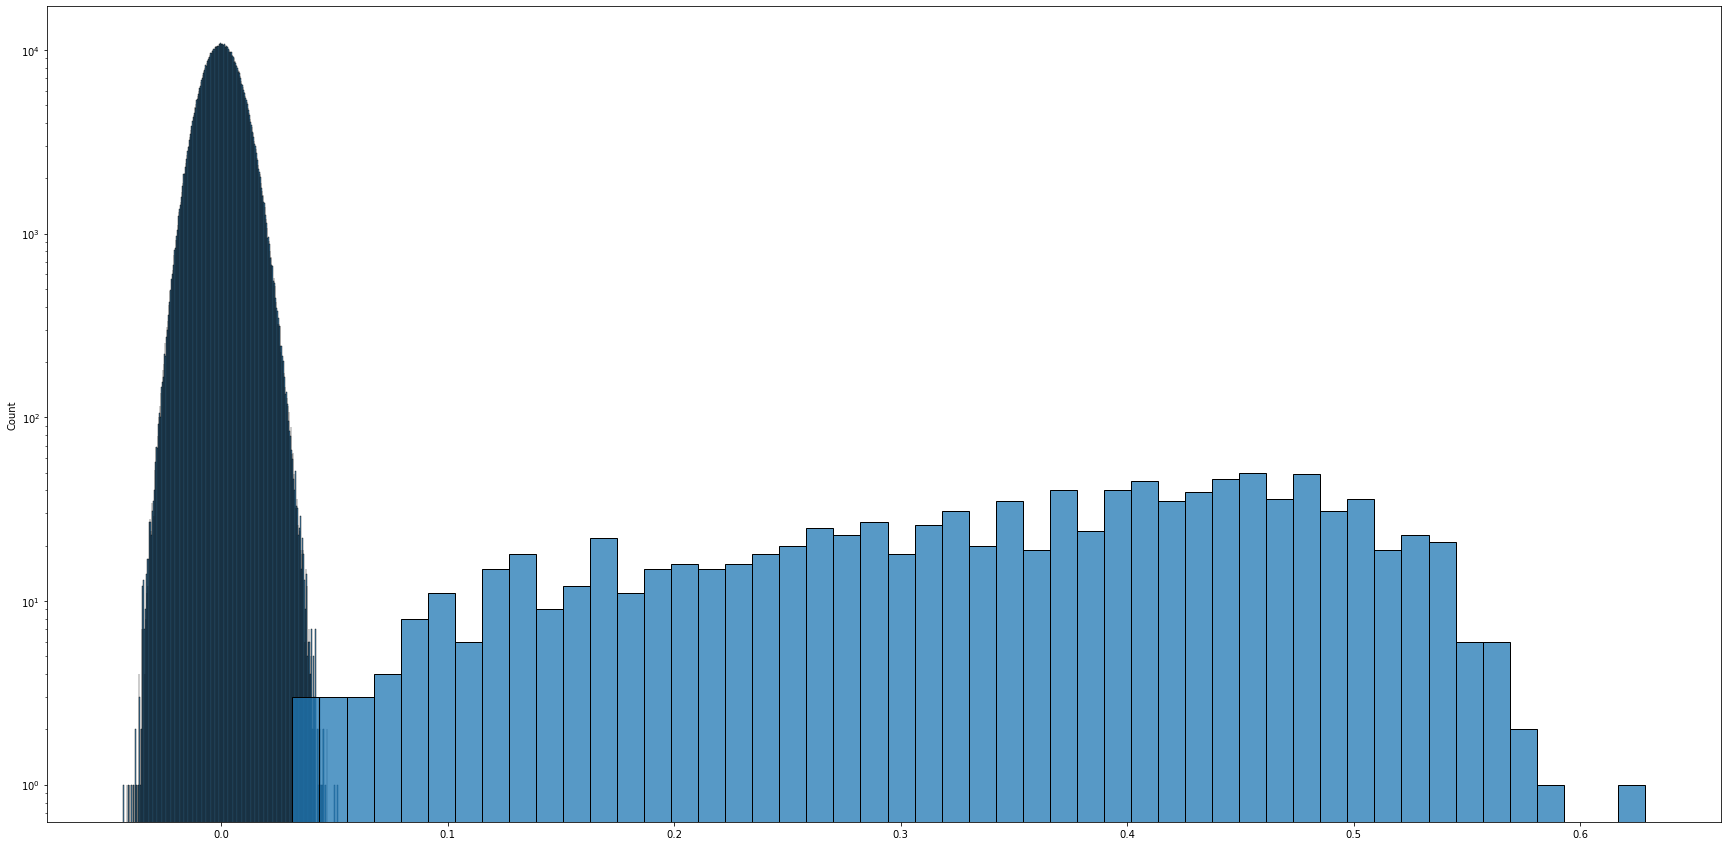

In [206]:
plt.figure(figsize=(30,15))
sns.histplot(inter.flatten(), log_scale=(False, True))
sns.histplot(intra, log_scale=(False, True), bins=50);

---

## Trying out ADC

In [212]:
module_path = os.path.abspath(os.path.join('../../adc/adc'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [213]:
from adc import ADC

In [219]:
vlad_pca.database.shape

(1000, 16384)

In [275]:
adc = ADC(m=256).fit(vlad_pca.database)

In [288]:
tmp = vlad_pca._vlad(query_tensor_pca[...,6])
adc.predict(tmp)

6

In [ ]:
adc_scores = np.zeros((999, 1000))

for i in 